# Energy Extrapolation

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/block-hczhai/block2-preview/blob/master/docs/source/tutorial/energy-extrapolation.ipynb)

In [1]:
!pip install block2==0.5.2rc5 -qq --progress-bar off --extra-index-url=https://block-hczhai.github.io/block2-preview/pypi/
!pip install pyscf==2.1.1 -qq --progress-bar off

## Introduction

In this tutorial we explain how to do DMRG energy extrapolation and also get an estimate of the error in the extrapolated energy. First we need to do a normal DMRG calculation, and then a DMRG with a reserve schedule, and then we do the energy extrapolation using the data from the reserve schedule. The DMRG energy is extrapolated using a linear fit for discarded weight vs energies for different bond dimensions. The error is estimated as one fifth of the extrapolation distance, as a convention. It is not recommended to use the normal DMRG data for the extrapolation because the energy for each bond dimension may not be fully converged. For the same reason, the energy at the largest bond dimension may also be excluded from the extrapolation.

First, we prepare the integrals and the MPO and the initial guess for the MPS.

In [2]:
import numpy as np
from pyblock2._pyscf.ao2mo import integrals as itg
from pyblock2.driver.core import DMRGDriver, SymmetryTypes

from pyscf import gto, scf

mol = gto.M(atom='C 0 0 0; C 0 0 1.2425', basis='ccpvdz', symmetry='d2h')
mf = scf.RHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_rhf_integrals(mf,
    ncore=2, ncas=26, g2e_symm=8)

print("NCAS = %d NCASELEC = %d" % (ncas, n_elec))
driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SU2,
                    stack_mem=4 << 30, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)
mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=1)
ket = driver.get_random_mps(tag="KET", bond_dim=250, nroots=1)

converged SCF energy = -75.3869023777058
NCAS = 26 NCASELEC = 8
integral symmetrize error =  7.237728341514619e-12
integral cutoff error =  3.0907247248324555e-20
mpo terms =      28590

Build MPO | Nsites =    26 | Nterms =      28590 | Algorithm = FastBIP | Cutoff = 1.00e-20
 Site =     0 /    26 .. Mmpo =    13 DW = 0.00e+00 NNZ =       13 SPT = 0.0000 Tmvc = 0.002 T = 0.012
 Site =     1 /    26 .. Mmpo =    42 DW = 0.00e+00 NNZ =       69 SPT = 0.8736 Tmvc = 0.003 T = 0.014
 Site =     2 /    26 .. Mmpo =    80 DW = 0.00e+00 NNZ =      201 SPT = 0.9402 Tmvc = 0.005 T = 0.022
 Site =     3 /    26 .. Mmpo =   126 DW = 0.00e+00 NNZ =      271 SPT = 0.9731 Tmvc = 0.005 T = 0.026
 Site =     4 /    26 .. Mmpo =   164 DW = 0.00e+00 NNZ =      497 SPT = 0.9759 Tmvc = 0.006 T = 0.025
 Site =     5 /    26 .. Mmpo =   210 DW = 0.00e+00 NNZ =      681 SPT = 0.9802 Tmvc = 0.009 T = 0.030
 Site =     6 /    26 .. Mmpo =   264 DW = 0.00e+00 NNZ =      831 SPT = 0.9850 Tmvc = 0.009 T = 0.029
 

## The Normal Schedule

First, we do a DMRG with the normal schedule (namely, the bond dimension increses). We first do 20 2-site sweeps, and then 8 1-site sweeps when it is close to convergence, which is cheaper.

In [3]:
bond_dims = [250] * 4 + [500] * 4 + [750] * 4 + [1000] * 4
noises = [1e-4] * 4 + [1e-5] * 12 + [0]
thrds = [1e-8] * 20

energy = driver.dmrg(mpo, ket, n_sweeps=28, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=2, twosite_to_onesite=20)
print('DMRG energy (variational) = %20.15f' % energy)

Environment initialization | Nsites =    26 | Center =     0
 INIT-R <-- Site =   23 ..  Bmem =   200 B Rmem =   200 B T = 0.00
 INIT-R <-- Site =   22 ..  Bmem = 2.47 KB Rmem = 2.47 KB T = 0.00
 INIT-R <-- Site =   21 ..  Bmem = 22.6 KB Rmem = 22.6 KB T = 0.01
 INIT-R <-- Site =   20 ..  Bmem =  237 KB Rmem =  237 KB T = 0.02
 INIT-R <-- Site =   19 ..  Bmem = 3.46 MB Rmem = 1.62 MB T = 0.11
 INIT-R <-- Site =   18 ..  Bmem = 25.7 MB Rmem = 1.91 MB T = 0.38
 INIT-R <-- Site =   17 ..  Bmem = 31.7 MB Rmem = 2.39 MB T = 0.48
 INIT-R <-- Site =   16 ..  Bmem = 40.6 MB Rmem = 3.04 MB T = 0.73
 INIT-R <-- Site =   15 ..  Bmem = 51.7 MB Rmem = 3.84 MB T = 0.94
 INIT-R <-- Site =   14 ..  Bmem = 66.2 MB Rmem = 4.84 MB T = 1.50
 INIT-R <-- Site =   13 ..  Bmem = 83.1 MB Rmem = 6.77 MB T = 2.07
 INIT-R <-- Site =   12 ..  Bmem =  116 MB Rmem = 8.38 MB T = 6.14
 INIT-R <-- Site =   11 ..  Bmem =  126 MB Rmem = 10.0 MB T = 6.20
 INIT-R <-- Site =   10 ..  Bmem =  143 MB Rmem = 9.48 MB T = 14.06


## The Reverse Schedule

For the reverse schedule, we decrease the bond dimension to make the energy at each bond dimension fully converged. The noise should be zero. The MPS is first changed from the 1-site format to the 2-site format. And the reverse schedule has to be done fully using the 2-site DMRG (since 1-site DMRG with zero noise will generate close-to-zero discarded weights). The energy convergence tolerance is set to zero to prevent early stop.

Note that the reverse schedule will destroy the data in the optimized MPS. We can first backup the MPS by copying it to another tag ``KET-ORIG``. If you want to later compute the properties on the optimized MPS, the ``ket_orig`` MPS should be used. If you want to restart a calculation from the MPS (automatically) stored in the scratch foloder, you can load it using its tag (for example, using ``ket = driver.load_mps(tag='KET-ORIG')``.

In [5]:
bond_dims = [800] * 4 + [600] * 4 + [400] * 4 + [200] * 4
noises = [0] * 16
thrds = [1e-8] * 16

ket_orig = ket.deep_copy('KET-ORIG')
ket_orig.info.save_data(driver.scratch + "/%s-mps_info.bin" % ket_orig.info.tag)

ket = driver.adjust_mps(ket, dot=2)[0]
energy = driver.dmrg(mpo, ket, n_sweeps=16, bond_dims=bond_dims, noises=noises,
                     tol=0, thrds=thrds, iprint=2)

Environment initialization | Nsites =    26 | Center =     0
 INIT-R <-- Site =   23 ..  Bmem =   200 B Rmem =   200 B T = 0.00
 INIT-R <-- Site =   22 ..  Bmem = 2.47 KB Rmem = 2.47 KB T = 0.00
 INIT-R <-- Site =   21 ..  Bmem = 22.6 KB Rmem = 19.5 KB T = 0.00
 INIT-R <-- Site =   20 ..  Bmem =  200 KB Rmem =  146 KB T = 0.01
 INIT-R <-- Site =   19 ..  Bmem = 2.04 MB Rmem = 1.16 MB T = 0.04
 INIT-R <-- Site =   18 ..  Bmem = 16.5 MB Rmem = 4.84 MB T = 0.10
 INIT-R <-- Site =   17 ..  Bmem = 67.6 MB Rmem = 18.5 MB T = 0.28
 INIT-R <-- Site =   16 ..  Bmem =  248 MB Rmem = 44.2 MB T = 0.69
 INIT-R <-- Site =   15 ..  Bmem =  580 MB Rmem = 52.9 MB T = 1.69
 INIT-R <-- Site =   14 ..  Bmem =  726 MB Rmem = 70.0 MB T = 2.32
 INIT-R <-- Site =   13 ..  Bmem =  957 MB Rmem = 83.6 MB T = 2.71
 INIT-R <-- Site =   12 ..  Bmem = 1.10 GB Rmem =  100 MB T = 3.00
 INIT-R <-- Site =   11 ..  Bmem = 1.14 GB Rmem =  103 MB T = 3.78
 INIT-R <-- Site =   10 ..  Bmem = 1.09 GB Rmem = 98.6 MB T = 7.72
 

## Energy Extrapolation

We can get the extrapolated energy using linear fitting.

In [7]:
import scipy.stats

ds, dws, eners = driver.get_dmrg_results()
print('BOND DIMS         = ', ds[3::4])
print('Discarded Weights = ', dws[3::4])
print('Energies          = ', eners[3::4, 0])
reg = scipy.stats.linregress(dws[3::4], eners[3::4, 0])
emin, emax = min(eners[3::4, 0]), max(eners[3::4, 0])
print('DMRG energy (extrapolated) = %20.15f +/- %15.10f' %
      (reg.intercept, abs(reg.intercept - emin) / 5))

BOND DIMS         =  [800 600 400 200]
Discarded Weights =  [2.40365736e-06 8.40721063e-06 3.54005596e-05 1.03451119e-04]
Energies          =  [-75.72840386 -75.72822331 -75.72770128 -75.72473353]
DMRG energy (extrapolated) =  -75.728636679111119 +/-    0.0000465644


Finally, we plot the energy extrapolation.

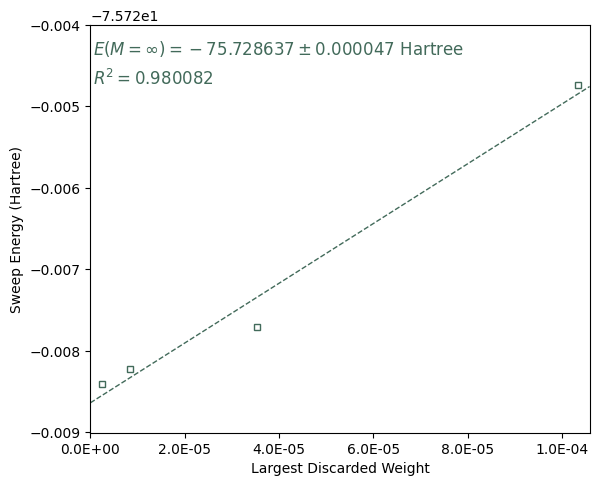

In [9]:
import matplotlib.pyplot as plt
from matplotlib import ticker
de = emax - emin
x_reg = np.array([0, dws[-1] + dws[3]])
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1E}"))
plt.plot(x_reg, reg.intercept + reg.slope * x_reg, '--', linewidth=1, color='#426A5A')
plt.plot(dws[3::4], eners[3::4, 0], ' ', marker='s', mfc='white', mec='#426A5A', color='#426A5A', markersize=5)
plt.text(dws[3] * 0.25, emax + de * 0.1, "$E(M=\\infty) = %.6f \\pm %.6f \\mathrm{\\ Hartree}$" %
    (reg.intercept, abs(reg.intercept - emin) / 5), color='#426A5A', fontsize=12)
plt.text(dws[3] * 0.25, emax - de * 0.0, "$R^2 = %.6f$" % (reg.rvalue ** 2),
    color='#426A5A', fontsize=12)
plt.xlim((0, dws[-1] + dws[3]))
plt.ylim((reg.intercept - de * 0.1, emax + de * 0.2))
plt.xlabel("Largest Discarded Weight")
plt.ylabel("Sweep Energy (Hartree)")
plt.subplots_adjust(left=0.17, bottom=0.1, right=0.95, top=0.95)